### NLP Transformers, Vision Transformers

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = 20000)

maxlen = 200
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [10]:
class TokenPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocabsize, embed_dim):
        super(TokenPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocabsize, output_dim=embed_dim)
        self.position_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = self.position_emb(positions)
        x = self.token_emb(inputs)
        return x + positions


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [25]:
embed_dim = 32     # Embedding size for each token
num_heads = 2      # Number of attention heads
ff_dim = 32        # Hidden layer size in feed-forward network inside the transformer
dropout_rate = 0.1 # Dropout rate
dense_units = 20   # Size of dense hidden layer
num_classes = 1

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenPositionEmbedding(maxlen, 20000, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

# TODOs — uzupełnione:
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(dense_units, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # lub 'sigmoid' dla klasyfikacji binarnej

model = keras.Model(inputs=inputs, outputs=outputs)

In [26]:
BATCH_SIZE = 256
EPOCHS = 5

model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    BATCH_SIZE,
    EPOCHS,
    validation_split=0.2
)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 391ms/step - accuracy: 0.6053 - loss: 0.6553 - val_accuracy: 0.8266 - val_loss: 0.3780
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 386ms/step - accuracy: 0.8683 - loss: 0.3153 - val_accuracy: 0.8650 - val_loss: 0.3194
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 395ms/step - accuracy: 0.9242 - loss: 0.2036 - val_accuracy: 0.8876 - val_loss: 0.2793
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 392ms/step - accuracy: 0.9582 - loss: 0.1289 - val_accuracy: 0.8658 - val_loss: 0.3674
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 384ms/step - accuracy: 0.9764 - loss: 0.0825 - val_accuracy: 0.8590 - val_loss: 0.5003


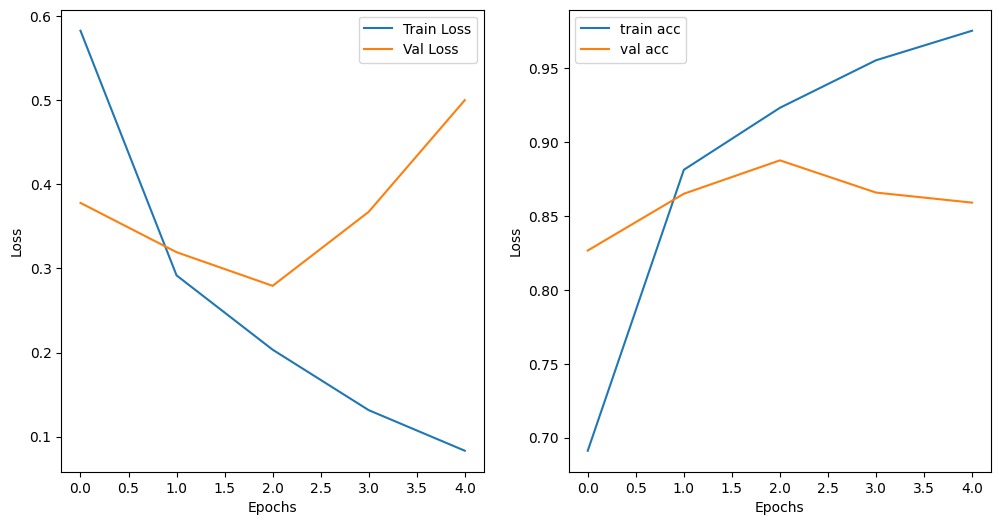

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(history_dict['loss'], label='Train Loss')
axs[0].plot(history_dict['val_loss'], label='Val Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history_dict['accuracy'], label='train acc')
axs[1].plot(history_dict['val_accuracy'], label='val acc')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()